In [20]:
#import libraries
from scipy.io import loadmat
import numpy as np
from scipy.optimize import minimize

from tkinter import *
from PIL import ImageGrab

In [21]:
 # Randomly initialises values of thetas between [-epsilon, +epsilon]
def initialise(a, b):
    epsilon = 0.15
    c = np.random.rand(a, b + 1) * (2 * epsilon) -epsilon  
    return c

The function performs feed-forward and backpropagation. 

Forward propagation: Input data is fed in the forward direction through the network. Each hidden layer accepts the input data, processes it as per the activation function and passes it to the successive layer. We will use the sigmoid function as our “activation function”.
Backward propagation: It is the practice of fine-tuning the weights of a neural net based on the error rate obtained in the previous iteration.
It also calculates cross-entropy costs for checking the errors between the prediction and original values. In the end, the gradient is calculated for the optimization objective.   

In [22]:
def neural_network(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lamb):
    # Weights are split back to Theta1, Theta2
    Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                        (hidden_layer_size, input_layer_size + 1))
    Theta2 = np.reshape(nn_params[hidden_layer_size * (input_layer_size + 1):], 
                        (num_labels, hidden_layer_size + 1))

    # Forward propagation
    m = X.shape[0]
    one_matrix = np.ones((m, 1))
    X = np.append(one_matrix, X, axis=1)  # Adding bias unit to first layer
    a1 = X
    z2 = np.dot(X, Theta1.transpose())
    a2 = 1 / (1 + np.exp(-z2))  # Activation for second layer
    one_matrix = np.ones((m, 1))
    a2 = np.append(one_matrix, a2, axis=1)  # Adding bias unit to hidden layer
    z3 = np.dot(a2, Theta2.transpose())
    a3 = 1 / (1 + np.exp(-z3))  # Activation for third layer

    # Changing the y labels into vectors of boolean values.
    # For each label between 0 and 9, there will be a vector of length 10
    # where the ith element will be 1 if the label equals i
    y_vect = np.zeros((m, 10))
    for i in range(m):
        y_vect[i, int(y[i])] = 1

    # Calculating cost function
    J = (1 / m) * (np.sum(np.sum(-y_vect * np.log(a3) - (1 - y_vect) * np.log(1 - a3)))) + (lamb / (2 * m)) * (
                sum(sum(pow(Theta1[:, 1:], 2))) + sum(sum(pow(Theta2[:, 1:], 2))))

    # backprop
    Delta3 = a3 - y_vect
    Delta2 = np.dot(Delta3, Theta2) * a2 * (1 - a2)
    Delta2 = Delta2[:, 1:]

    # gradient
    Theta1[:, 0] = 0
    Theta1_grad = (1 / m) * np.dot(Delta2.transpose(), a1) + (lamb / m) * Theta1
    Theta2[:, 0] = 0
    Theta2_grad = (1 / m) * np.dot(Delta3.transpose(), a2) + (lamb / m) * Theta2
    grad = np.concatenate((Theta1_grad.flatten(), Theta2_grad.flatten()))

    return J, grad

It performs forward propagation to predict the digit.

In [23]:
def predict(Theta1, Theta2, X):
    m = X.shape[0]
    one_matrix = np.ones((m, 1))
    X = np.append(one_matrix, X, axis=1)  # Adding bias unit to first layer
    z2 = np.dot(X, Theta1.transpose())
    a2 = 1 / (1 + np.exp(-z2))  # Activation for second layer
    one_matrix = np.ones((m, 1))
    a2 = np.append(one_matrix, a2, axis=1)  # Adding bias unit to hidden layer
    z3 = np.dot(a2, Theta2.transpose())
    a3 = 1 / (1 + np.exp(-z3))  # Activation for third layer
    p = (np.argmax(a3, axis=1))  # Predicting the class on the basis of max value of hypothesis
    return p

Importing all the required libraries, extract the data from mnist-original.mat file. Then features and labels will be separated from extracted data. After that data will be split into training (60,000) and testing (10,000) examples. Randomly initialize Thetas in the range of [-0.15, +0.15] to break symmetry and get better results. Further, the optimizer is called for the training of weights, to minimize the cost function for appropriate predictions. We have used the “minimize” optimizer from “scipy.optimize” library with “L-BFGS-B” method. We have calculated the test, the “training set accuracy and precision using “predict” function.

In [24]:
# Loading mat file
data = loadmat('mnist-original.mat')

# Extracting features from mat file
X = data['data']
X = X.transpose()

# Normalizing the data
X = X / 255

# Extracting labels from mat file
y = data['label']
y = y.flatten()

# Splitting data into training set with 60,000 examples
X_train = X[:60000, :]
y_train = y[:60000]

# Splitting data into testing set with 10,000 examples
X_test = X[60000:, :]
y_test = y[60000:]

m = X.shape[0]
input_layer_size = 784  # Images are of (28 X 28) px so there will be 784 features
hidden_layer_size = 100
num_labels = 10  # There are 10 classes [0, 9]

# Randomly initialising Thetas
initial_Theta1 = initialise(hidden_layer_size, input_layer_size)
initial_Theta2 = initialise(num_labels, hidden_layer_size)

# Unrolling parameters into a single column vector
initial_nn_params = np.concatenate((initial_Theta1.flatten(), initial_Theta2.flatten()))
maxiter = 100
lambda_reg = 0.1  # To avoid overfitting
myargs = (input_layer_size, hidden_layer_size, num_labels, X_train, y_train, lambda_reg)

# Calling minimize function to minimize cost function and to train weights
results = minimize(neural_network, x0=initial_nn_params, args=myargs, 
          options={'disp': True, 'maxiter': maxiter}, method="L-BFGS-B", jac=True)

nn_params = results["x"]  # Trained Theta is extracted

# Weights are split back to Theta1, Theta2
Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)], (
                              hidden_layer_size, input_layer_size + 1))  # shape = (100, 785)
Theta2 = np.reshape(nn_params[hidden_layer_size * (input_layer_size + 1):], 
                      (num_labels, hidden_layer_size + 1))  # shape = (10, 101)

# Checking test set accuracy of our model
pred = predict(Theta1, Theta2, X_test)
print('Test Set Accuracy: {:f}'.format((np.mean(pred == y_test) * 100)))

# Checking train set accuracy of our model
pred = predict(Theta1, Theta2, X_train)
print('Training Set Accuracy: {:f}'.format((np.mean(pred == y_train) * 100)))

# Evaluating precision of our model
true_positive = 0
for i in range(len(pred)):
    if pred[i] == y_train[i]:
        true_positive += 1
false_positive = len(y_train) - true_positive
print('Precision =', true_positive/(true_positive + false_positive))

# Saving Thetas in .txt file
np.savetxt('Theta1.txt', Theta1, delimiter=' ')
np.savetxt('Theta2.txt', Theta2, delimiter=' ')

Test Set Accuracy: 97.540000
Training Set Accuracy: 99.535000
Precision = 0.99535


It launches a GUI for writing digits. The image of the digit is stored in the same directory after converting it to grayscale and reducing the size to (28 X 28) pixels. 

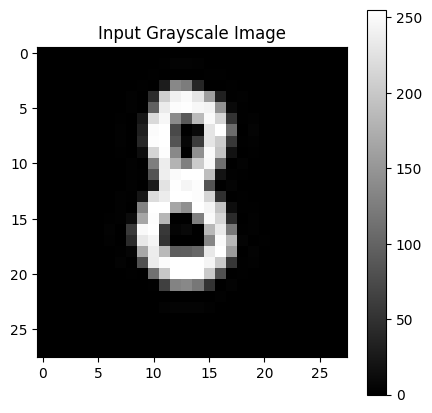

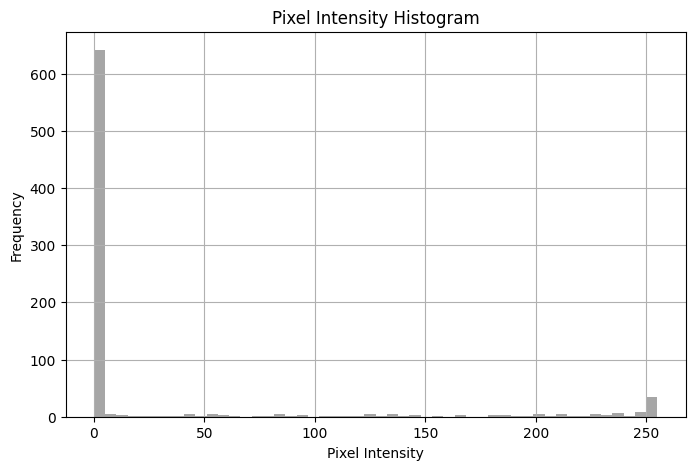

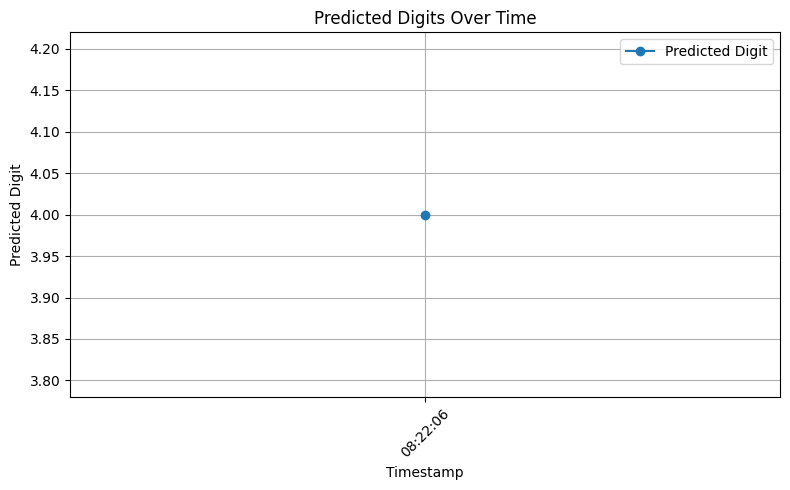

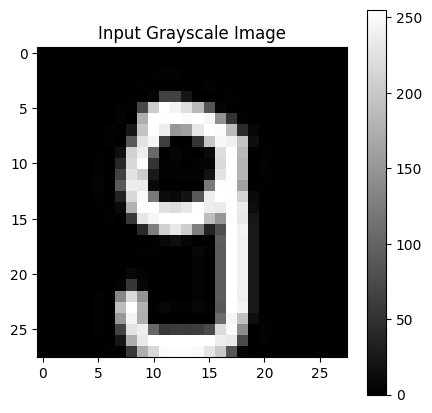

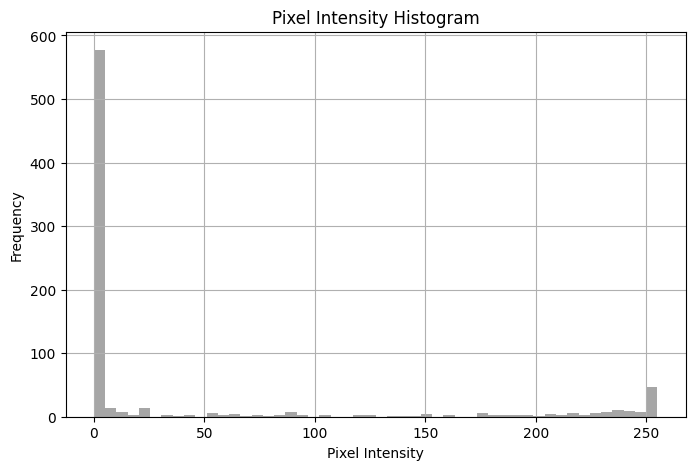

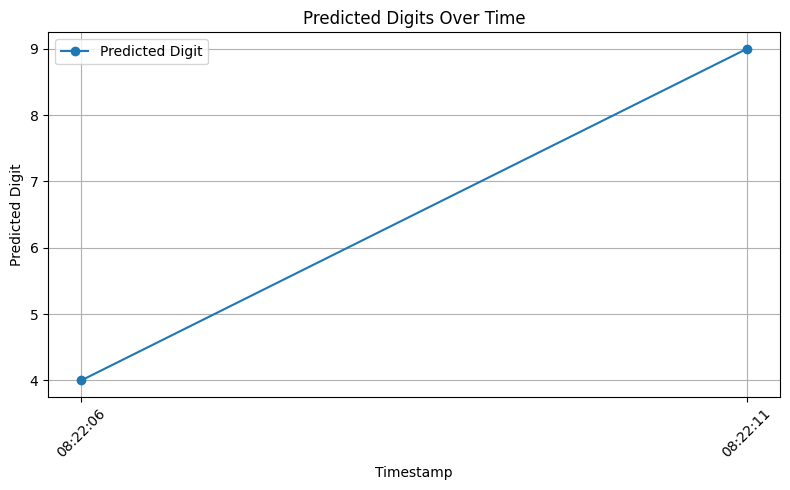

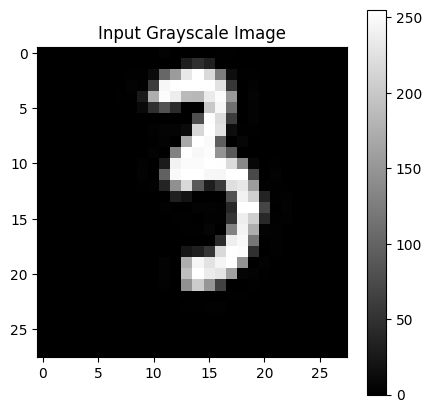

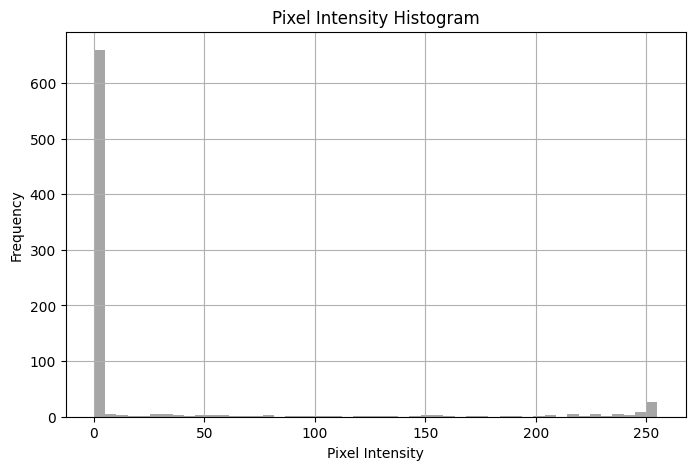

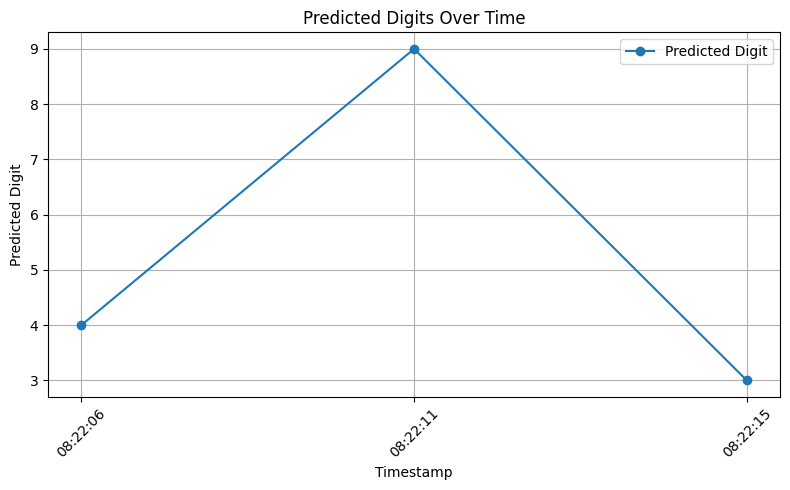

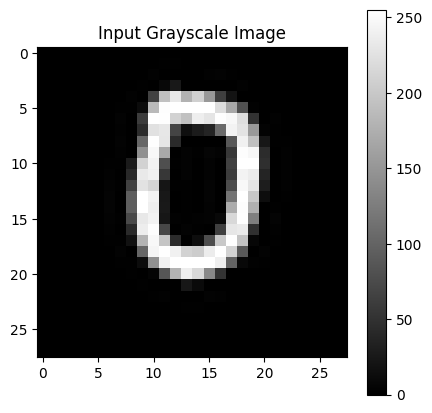

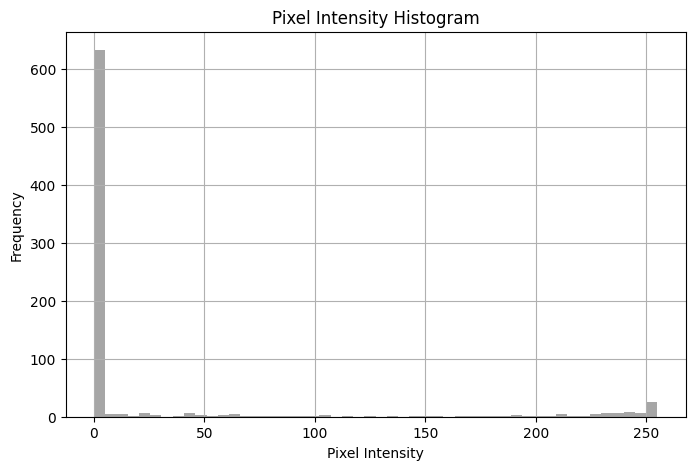

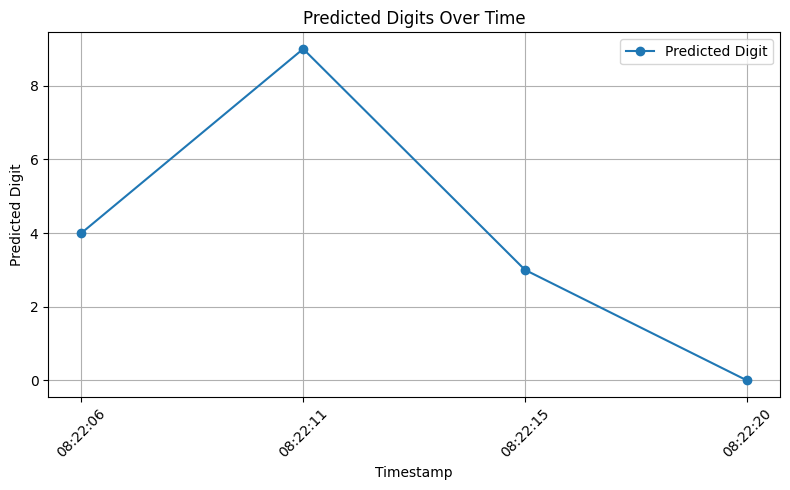

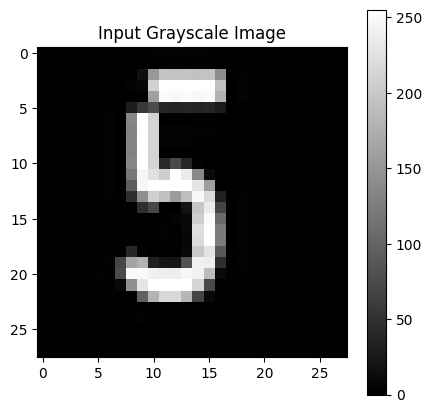

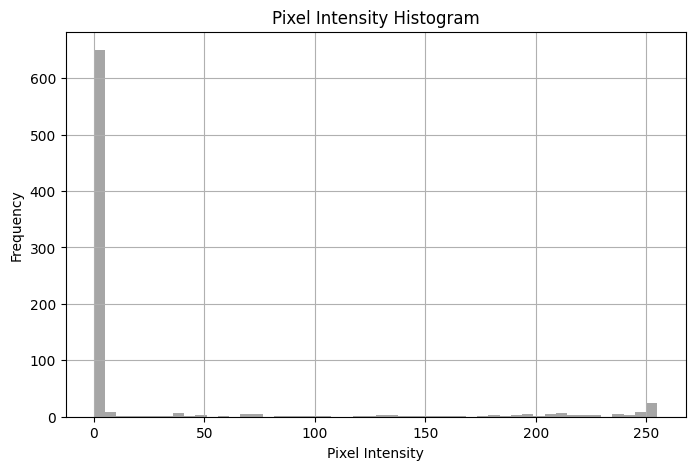

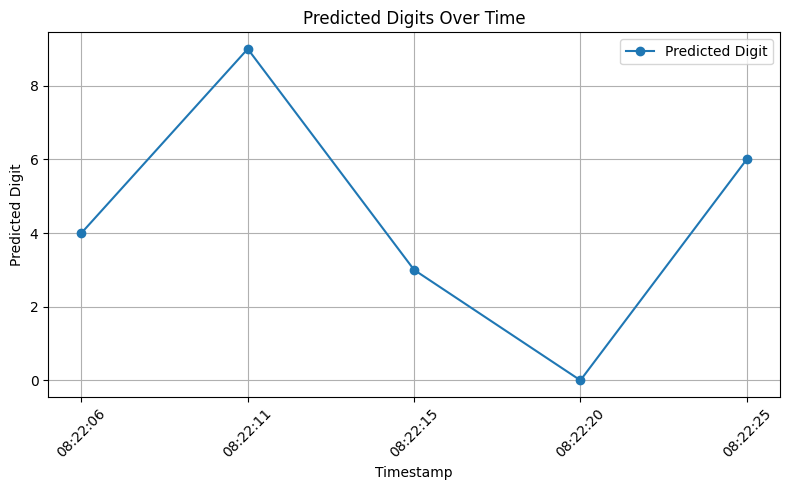

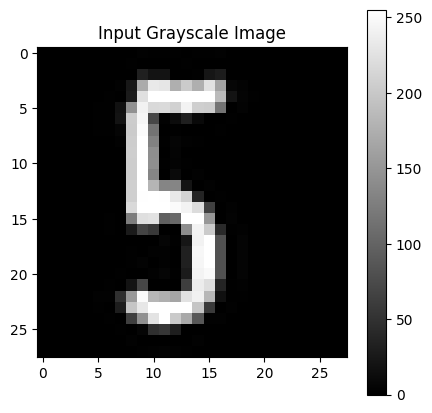

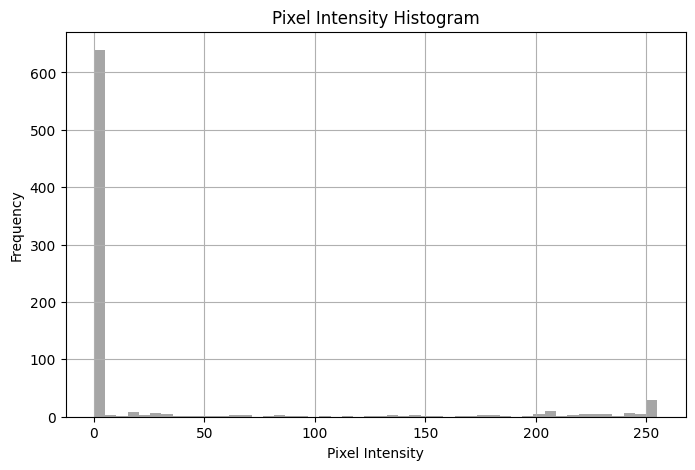

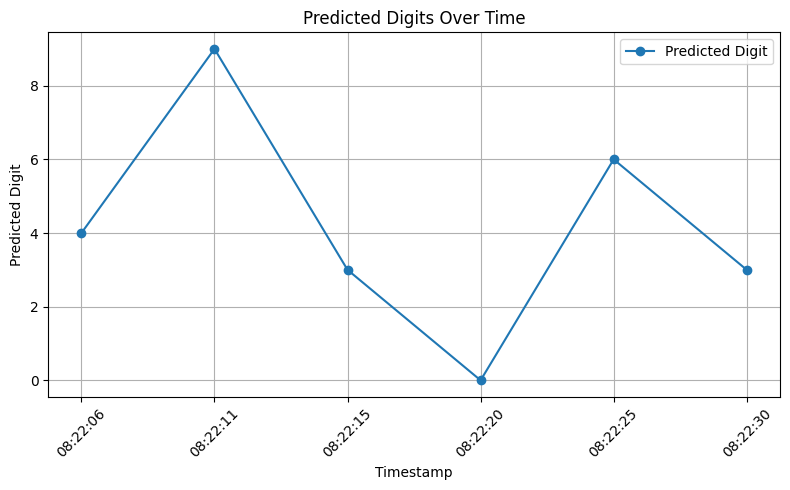

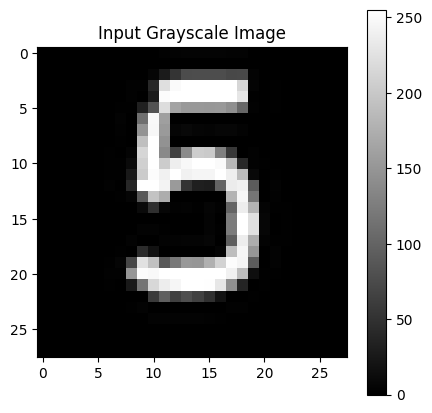

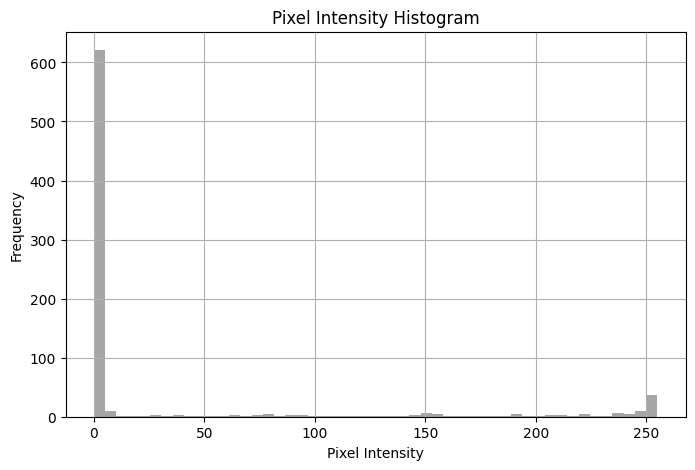

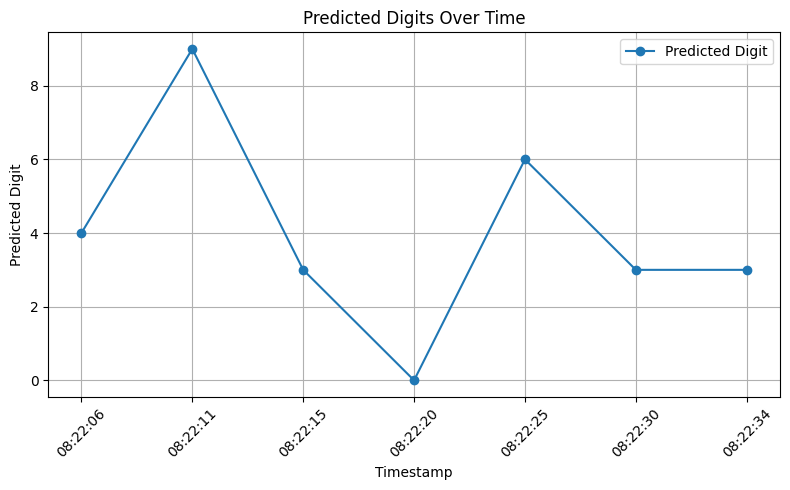

KeyboardInterrupt: 

In [26]:
from tkinter import *
from tkinter import ttk
from PIL import Image, ImageDraw, ImageOps
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime



window = Tk()
window.title("Handwritten Digit Recognition")
l1 = Label()
drawing_image = Image.new("L", (350, 290), "black")
draw = ImageDraw.Draw(drawing_image)

predictions = []
timestamps = []

# Function to display the grayscale image
def show_grayscale_image(image):
    plt.figure(figsize=(5, 5))
    plt.title("Input Grayscale Image")
    plt.imshow(image, cmap='gray')
    plt.colorbar()
    plt.show()

# Function to plot predictions over time
def plot_predictions():
    if len(predictions) > 0:
        plt.figure(figsize=(8, 5))
        plt.plot(timestamps, predictions, marker='o', label="Predicted Digit")
        plt.title("Predicted Digits Over Time")
        plt.xlabel("Timestamp")
        plt.ylabel("Predicted Digit")
        plt.grid(True)
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# Function to plot pixel intensity histogram
def plot_pixel_histogram(image):
    image_array = np.asarray(image)
    flattened_array = image_array.flatten()
    plt.figure(figsize=(8, 5))
    plt.hist(flattened_array, bins=50, color='gray', alpha=0.7)
    plt.title("Pixel Intensity Histogram")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

# Function to visualize weights (optional, if weights are small matrices)
def visualize_weights(weights, title="Theta Visualization"):
    num_weights = weights.shape[0]
    fig, axs = plt.subplots(1, num_weights, figsize=(15, 5))
    for i in range(num_weights):
        axs[i].imshow(weights[i].reshape(28, 28), cmap='gray')
        axs[i].set_title(f"Weight {i + 1}")
    plt.suptitle(title)
    plt.show()
def MyProject():
    global l1, drawing_image, predictions, timestamps

    # Resize the image to (28, 28)
    img_resized = drawing_image.resize((28, 28), Image.Resampling.LANCZOS)
    img_resized.save("captured_digit.png")  # Save to inspect the digit

    # Convert the image to a grayscale matrix
    x = np.asarray(img_resized)
    vec = x.flatten().reshape(1, -1)  # Vector of shape (1, 784)

    # Normalize the vector
    vec_normalized = vec / 255.0

    # Load weights
    Theta1 = np.loadtxt('Theta1.txt')
    Theta2 = np.loadtxt('Theta2.txt')

    # Predict the digit
    pred = predict(Theta1, Theta2, vec_normalized)
    #print(vec_normalized)  # Debugging
    predictions.append(pred[0])
    timestamps.append(datetime.now().strftime("%H:%M:%S"))
    
    # Display the result
    l1 = Label(window, text="Digit = " + str(pred[0]), font=('Algerian', 20))
    l1.place(x=230, y=420)
    show_grayscale_image(img_resized)
    plot_pixel_histogram(img_resized)
    plot_predictions()


lastx, lasty = None, None


# Clear the canvas and image
def clear_widget():
    global cv, l1, drawing_image, draw
    cv.delete("all")
    drawing_image = Image.new("L", (350, 290), "black")
    draw = ImageDraw.Draw(drawing_image)
    l1.destroy()


# Activate canvas
def event_activation(event):
    global lastx, lasty
    cv.bind('<B1-Motion>', draw_lines)
    lastx, lasty = event.x, event.y


# Draw lines on the canvas and update the image
def draw_lines(event):
    global lastx, lasty, draw
    x, y = event.x, event.y
    cv.create_line((lastx, lasty, x, y), width=30, fill='white', capstyle=ROUND, smooth=TRUE, splinesteps=12)
    draw.line((lastx, lasty, x, y), fill="white", width=30)
    lastx, lasty = x, y


# Label
L1 = Label(window, text="Handwritten Digit Recognition", font=('Algerian', 25), fg="blue")
L1.place(x=35, y=10)

# Button to clear canvas
b1 = Button(window, text="1. Clear Canvas", font=('Algerian', 15), bg="blue", fg="white", command=clear_widget)
b1.place(x=120, y=370)

# Button to predict digit drawn on canvas
b2 = Button(window, text="2. Prediction", font=('Algerian', 15), bg="pink", fg="white", command=MyProject)
b2.place(x=320, y=370)

# Setting properties of canvas
cv = Canvas(window, width=350, height=290, bg='black')
cv.place(x=120, y=70)
cv.bind('<Button-1>', event_activation)
window.bind('<F5>', lambda event: plot_predictions())
window.geometry("600x500")
window.mainloop()
